We are going to start with a simple implementation of Matrix Factorization without any kind baselines using PyTorch.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import pandas as pd
import torch

from surprise import Dataset, Reader

def set_df_to_index_based(df):
    """
    Transforms the Movielens Index into Python indices for PyTorch embeddings computation
    """
    df = df.astype({"uid": "int64", "iid": "int64"})
    df["uid"] = df["uid"] - 1
    df["iid"] = df["iid"] - 1
    return df

# Define a random state so that the train test splits can be reproducible
RANDOM_STATE = 128

# Add this path to use SciencePlots (it uses latex)
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.rcParams["figure.figsize"] = (100,100)
plt.style.use(['science', 'notebook'])

# Problem Specific constants
N_USERS = 943
N_ITEMS = 1682
N_FACTORS = 100 

### Generate train and test sets

In [2]:
# path to dataset file
file_path = "../ml-100k/u.data"
reader = Reader(line_format="user item rating timestamp", sep="\t")
data = Dataset.load_from_file(file_path, reader=reader)

# Get raw ratings from `Dataset` object
raw_ratings = data.raw_ratings

# Shuffle the raw ratings and select train and test splits (75 % / 25 %)
random.Random(RANDOM_STATE).shuffle(raw_ratings)
threshold = int(0.75 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

threshold_val = int(0.20 * len(train_raw_ratings))
val_raw_ratings = train_raw_ratings[:threshold_val]
train_raw_ratings = train_raw_ratings[threshold_val:]

In [3]:
# Transform surprise based objects to pandas dataframes
df_train = pd.DataFrame.from_records(train_raw_ratings, columns=["uid", "iid", "rating", "timestamp"])
df_val = pd.DataFrame.from_records(val_raw_ratings, columns=["uid", "iid", "rating", "timestamp"])
df_test = pd.DataFrame.from_records(test_raw_ratings, columns=["uid", "iid", "rating", "timestamp"])

In [4]:
df_train.head()

,uid,iid,rating,timestamp
0,497,53,3.0,879362178
1,123,165,5.0,879872672
2,873,348,3.0,891392577
3,790,249,3.0,884461849
4,372,100,3.0,876869388


In [5]:
df_train = set_df_to_index_based(df_train)

In [6]:
df_train.head()

,uid,iid,rating,timestamp
0,496,52,3.0,879362178
1,122,164,5.0,879872672
2,872,347,3.0,891392577
3,789,248,3.0,884461849
4,371,99,3.0,876869388


In [7]:
df_val.head()

,uid,iid,rating,timestamp
0,194,423,3.0,879548121
1,104,333,2.0,888442305
2,41,174,4.0,890687264
3,489,751,5.0,891362773
4,593,288,4.0,877728878


In [8]:
df_val = set_df_to_index_based(df_val)

In [9]:
df_test.head()

,uid,iid,rating,timestamp
0,5,24,4.0,879198229
1,716,501,5.0,879796215
2,590,476,3.0,879439345
3,601,98,3.0,876348526
4,896,1672,2.0,887159554


In [10]:
df_test = set_df_to_index_based(df_test)

In [11]:
df_test.head()

,uid,iid,rating,timestamp
0,4,23,4.0,879198229
1,715,500,5.0,879796215
2,589,475,3.0,879439345
3,600,97,3.0,876348526
4,895,1671,2.0,887159554


In [12]:
df_train.shape

(60000, 4)

In [13]:
df_val.shape

(15000, 4)

In [14]:
df_test.shape

(25000, 4)

In [28]:
df_train.to_csv("../data/df_train.csv", header=True, index=False)
df_val.to_csv("../data/df_val.csv", header=True, index=False)
df_test.to_csv("../data/df_test.csv", header=True, index=False)

# Generate DataLoaders and Datasets

In [15]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class MovielensDataset(Dataset):
    def __init__(self, path, transform=None):
        self.ratings = pd.read_csv(path).values
        self.path = path
        self.transform= transform
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        """
        Returns uid, iid and rating
        """
        return int(self.ratings[idx][0]), int(self.ratings[idx][1]), float(self.ratings[idx][2])

In [16]:
train_dataset = MovielensDataset(path="../data/df_train.csv", transform=ToTensor())
validation_dataset = MovielensDataset(path="../data/df_val.csv", transform=ToTensor())
test_dataset = MovielensDataset(path="../data/df_test.csv", transform=ToTensor())

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Matrix Factorization

In [28]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=30):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.user_bias = torch.nn.Embedding(n_users, 1)
            
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.item_bias = torch.nn.Embedding(n_items, 1) 
        
        for param in self.parameters():
            torch.nn.init.normal_(param, std=0.01)  
    
    def forward(self, user, item):
        Q = self.user_factors(user)
        bq = self.user_bias(user).flatten()

        I = self.item_factors(item)
        bi = self.item_bias(item).flatten()

        return (Q*I).sum(-1) + bq + bi

In [29]:
model = MatrixFactorization(N_USERS, N_ITEMS, n_factors=N_FACTORS)

In [124]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

In [125]:
train_loss = []
val_loss = []

for e in range(30):
    train_losses = []
    val_losses = []
    
    for uid, iid, rating in train_dataloader:
        # Set gradients to zero
        optimizer.zero_grad()
        rating_hat = model(uid.to(torch.long), iid.to(torch.long))
        loss = loss_func(rating_hat, rating.to(torch.float))

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        train_losses.append(float(loss))
    
    for uid, iid, rating in validation_dataloader:
        rating_hat = model(uid, iid)
        loss = loss_func(rating_hat, rating.to(torch.float))
        val_losses.append(float(loss))
    
    train_loss.append(np.mean(train_losses))
    val_loss.append(np.mean(val_losses))
    print(f"Epoch {e + 1} | Training loss: {train_loss[-1]} | Validation loss: {val_loss[-1]}")
    

Epoch 1 | Training loss: 11.270952577793851 | Validation loss: 5.4500576924469515
Epoch 2 | Training loss: 2.383737066958813 | Validation loss: 1.391197606668634
Epoch 3 | Training loss: 1.1577652565976406 | Validation loss: 1.0781115141965576
Epoch 4 | Training loss: 0.986298771614724 | Validation loss: 0.9922341350781716
Epoch 5 | Training loss: 0.9283335896248514 | Validation loss: 0.9587470444582277
Epoch 6 | Training loss: 0.8990206246680402 | Validation loss: 0.9415270878096759
Epoch 7 | Training loss: 0.8803015077367742 | Validation loss: 0.9323273129382376
Epoch 8 | Training loss: 0.8648680273522722 | Validation loss: 0.9251314149064532
Epoch 9 | Training loss: 0.8486862015216908 | Validation loss: 0.9143248958102728
Epoch 10 | Training loss: 0.8315889992612473 | Validation loss: 0.90930929729494
Epoch 11 | Training loss: 0.8168447593425182 | Validation loss: 0.8997251936944864
Epoch 12 | Training loss: 0.7979193000083274 | Validation loss: 0.8939306089433573
Epoch 13 | Trainin

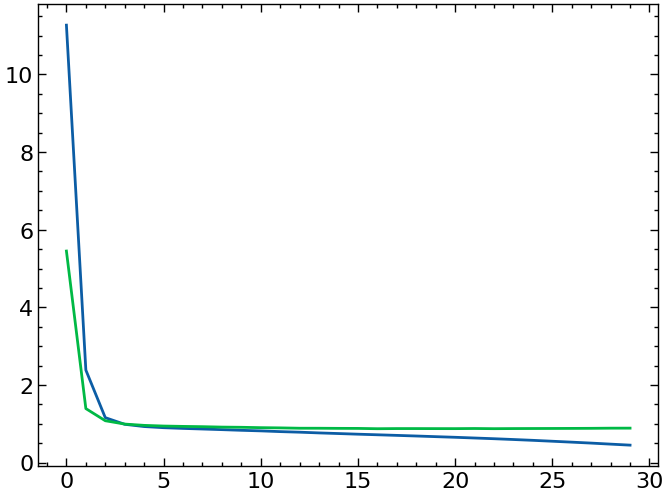

In [126]:
plt.plot(train_loss)
plt.plot(val_loss)

In [132]:
test_losses = []

for uid, iid, rating in test_dataloader:
    rating_hat = model(uid, iid)
    loss = torch.sqrt(loss_func(rating_hat, rating.to(torch.float)))
    test_losses.append(float(loss))

In [133]:
np.mean(test_losses)

0.9486468482990654